In [1]:
import torch.nn.functional as F
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parameter as Parameter
import time
import random
import torchvision
import torchvision.transforms as transforms
from pathlib import Path
import matplotlib.pyplot as plt
import csv
import os
print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

PyTorch Version:  1.13.0
Torchvision Version:  0.14.0


In [2]:
folder = r'./stochastic_1_1'

net_fn = os.path.join(folder, 'binarized_net.pt')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device type:", device)

batch_size = 50 # the original paper use batch size of 50 on CIFAR-10

device type: cuda


In [3]:
transform = transforms.Compose(
  [transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def hard_sigmoid(x):
  return torch.clamp((x+1)/2, 0, 1) # The clip function

def binarize(W, binary="stochastic"):
  if binary == "stochastic": # Stochastic binarization
    sigma = hard_sigmoid(W)
    Wb = torch.distributions.binomial.Binomial(total_count=1, probs=sigma).sample()
    Wb = torch.where(Wb==0, torch.tensor(-1., device=device), torch.tensor(1., device=device)) # If we want to binarize the network with 0 and 1, we can delete this line
  elif binary == "deterministic": # Deterministic binarization with 1 and -1
    Wb = torch.where(W >= 0, torch.tensor(1., device=device), torch.tensor(-1., device=device)) # https://pytorch.org/docs/stable/generated/torch.where.html
    # Wb = torch.where(W >= 0.5, torch.tensor(1., device=device), torch.tensor(0, device=device)) # Deterministic binarization with 1 and 0
  else:
    Wb = W
  return Wb

In [5]:
class binConv2d(nn.Conv2d):
  def __init__(self, *kargs, **kwargs):
    super(binConv2d, self).__init__(*kargs, **kwargs)
    self.require_binarization = True
  
  def forward(self, input):
    if not hasattr(self.weight, 'org'):
      self.weight.org = self.weight.data.clone()
    if self.require_binarization == True:
      self.weight.data = binarize(self.weight.org, binary="stochastic")
    else:
      self.weight.data.copy_(self.weight.org)
    output = nn.functional.conv2d(input, self.weight, None, self.stride, self.padding, self.dilation, self.groups)
    return output

  def set_binarization_flag(self, require_binarization=True):
    self.require_binarization = require_binarization

class binLinear(nn.Linear):
  def __init__(self, *kargs, **kwargs):
    super(binLinear, self).__init__(*kargs, **kwargs)
    self.require_binarization = True
  
  def forward(self, input):
    if not hasattr(self.weight, 'org'):
      self.weight.org=self.weight.data.clone()
    if self.require_binarization == True:
      self.weight.data = binarize(self.weight.org, binary="stochastic")
    else:
      self.weight.data.copy_(self.weight.org)
    output = nn.functional.linear(input, self.weight, None)
    return output
  
  def set_binarization_flag(self, require_binarization=True):
    self.require_binarization = require_binarization

In [6]:
class BinaryNet(nn.Module):
  def __init__(self):
    super(BinaryNet, self).__init__()
    self.features = nn.Sequential(
        binConv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=128, affine=False),
        # nn.BatchNorm2d(num_features=128, affine=True),
        nn.ReLU(),
        binConv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=128, affine=False),
        # nn.BatchNorm2d(num_features=128, affine=True),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

        binConv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=256, affine=False),
        # nn.BatchNorm2d(num_features=256, affine=True),
        nn.ReLU(),
        binConv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=256, affine=False),
        # nn.BatchNorm2d(num_features=256, affine=True),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

        binConv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=512, affine=False),
        # nn.BatchNorm2d(num_features=512, affine=True),
        nn.ReLU(),
        binConv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=512, affine=False),
        # nn.BatchNorm2d(num_features=512, affine=True),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

        binConv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=1024, affine=False),
        # nn.BatchNorm2d(num_features=1024, affine=True),
        nn.ReLU(),
        binConv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=1024, affine=False),
        # nn.BatchNorm2d(num_features=1024, affine=True),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    )
    self.classifiers = nn.Sequential(
        binLinear(4096, 1024),
        nn.BatchNorm1d(1024, affine=False),
        # nn.BatchNorm1d(1024, affine=True),
        binLinear(1024, 10),
        nn.BatchNorm1d(10, affine=False),
        # nn.BatchNorm1d(10, affine=True),
    )

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.shape[0], -1)
    x = self.classifiers(x)
    return x

  
  def set_binarization_flag(self, require_binarization=True):
    for layer in self.features:
      if isinstance(layer, nn.Conv2d):
        layer.set_binarization_flag(require_binarization=require_binarization)

    for layer in self.classifiers:
      if isinstance(layer, nn.Linear):
        layer.set_binarization_flag(require_binarization=require_binarization)

In [7]:
def init_weight(layer): # https://pytorch.org/docs/stable/nn.init.html
  if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
    torch.nn.init.uniform_(layer.weight, a=0, b=1)
    # torch.nn.init.normal_(tensor=layer.weight, mean=0.5, std=1)

In [8]:
# criterion = nn.HingeEmbeddingLoss(size_average=True)
criterion = nn.CrossEntropyLoss()
num_epochs = 500
LR_start = 3 * 1e-3
LR_fin = 2 * 1e-6
LR_decay = (LR_fin/LR_start)**(1./num_epochs)
LR = LR_start
net = BinaryNet()
# net.apply(fn=init_weight) # init weight for weight of +1 and 0
print("num_epochs:", num_epochs, " learning_rate_start:", LR_start, " learning_rate_final:", LR_fin, " learning_rate_decay:", LR_decay)
print(net)
net = net.to(device)

num_epochs: 500  learning_rate_start: 0.003  learning_rate_final: 2e-06  learning_rate_decay: 0.9854800059995851
BinaryNet(
  (features): Sequential(
    (0): binConv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): binConv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): binConv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (9): ReLU()
    (10): binConv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool

In [9]:
def validate_model(model, dataloader, n = None):
    
    # Set to evaluation mode rather than training mode
    model.eval()
    model.set_binarization_flag(require_binarization=False)
    print(model.features[0].require_binarization)
    print(model.classifiers[0].require_binarization)

    top1 = 0
    total = 0

    # Iterate over data stopping early if n is set
    for i, (inputs, labels) in enumerate(dataloader):
        if (n is not None and i >= n):
            break
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Run the model and collect the top 1 outputs.
        print('validate_model')
        # print(model.features[0].weight.data)
        outputs = model(inputs)
        # print(model.features[0].weight.data)
        _, predicted = torch.max(outputs, 1)
        # Gather statistics
        top1 += torch.sum(predicted == labels.data)
        total += len(outputs)

    top1_acc = 100 * top1.double() / total
    print('validate end')
    model.train()
    model.set_binarization_flag(require_binarization=True)
    return top1_acc

In [10]:
# def calculate_the_rate_of_0_in_layers(model):
#   the_rate_of_0_list = []
#   for layer in model.features:
#     if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
#       the_rate_of_0_list.append(1 - torch.mean(layer.weight).detach().cpu().numpy())

#   for layer in model.classifiers:
#     if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
#       the_rate_of_0_list.append(1 - torch.mean(layer.weight).detach().cpu().numpy())
#   return the_rate_of_0_list

# def calculate_the_rate_of_0_in_gradients(model):
#   the_rate_of_0_list = []
#   for layer in model.features:
#     if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
#       print(layer.weight.grad)
#       the_rate_of_0_list.append(1 - (torch.count_nonzero(layer.weight.grad) / torch.numel(layer.weight.grad)).detach().cpu().numpy())

#   for layer in model.classifiers:
#     if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
#       print(layer.weight.grad)
#       the_rate_of_0_list.append(1 - (torch.count_nonzero(layer.weight.grad) / torch.numel(layer.weight.grad)).detach().cpu().numpy())
#   return the_rate_of_0_list

def calculate_the_magnitude_of_gradients(model):
  the_magnitude_of_gradients = []
  for layer in model.features:
    if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
      # print(layer.weight.grad)
      the_magnitude_of_gradients.append(torch.mean(torch.abs(layer.weight.grad)).detach().cpu().numpy())

  for layer in model.classifiers:
    if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
      # print(layer.weight.grad)
      the_magnitude_of_gradients.append(torch.mean(torch.abs(layer.weight.grad)).detach().cpu().numpy())
  return the_magnitude_of_gradients

In [11]:
if Path(net_fn).is_file():
  net.load_state_dict(torch.load(net_fn)) # load file if previously executed
  print("Skipped Training. Loaded network")
else:
  train_loss_of_every_epoch = []
  validation_accuracy_of_every_epoch = []

  for epoch in range(num_epochs):
    running_loss = 0.0
    running_num = 0
    optimizer = torch.optim.Adam(net.parameters(), lr=LR)

    for i, data in enumerate(trainloader, 0):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      outputs = net(inputs) # forward

      loss = criterion(outputs, labels) # calculate loss.
      loss.backward() # Use binarized weights to compute derivatives to speed up.

      for p in list(net.parameters()):
        if hasattr(p,'org'):
          p.data.copy_(p.org)

      optimizer.step() # Use derivatives to update original weights rather than binarized weights.

      for p in list(net.parameters()):
        if hasattr(p,'org'):
          p.org.copy_(p.data.clamp_(-1, 1))

      # for p in list(net.parameters()):
      #   p.data = p.data.clamp_(-1, 1)

      running_loss += loss.item()
      running_num += batch_size

    
    # print("eopch: ", epoch+1, ", the magnitude of gradients: ", calculate_the_magnitude_of_gradients(model=net))
      
    print("eopch: ", epoch+1, ", learning rate: ", LR)
    LR = LR * LR_decay
    
    print("eopch: ", epoch+1, ", training loss: ", running_loss / running_num)
    train_loss_of_every_epoch.append(running_loss / running_num)

    top1_acc = validate_model(net, testloader)
    print("eopch: ", epoch+1, ", accuracy: ", top1_acc)
    validation_accuracy_of_every_epoch.append(top1_acc.detach().cpu().numpy())
    
  torch.save(net.state_dict(), net_fn)
  with open(os.path.join(folder, 'train_loss_and_validation_accuracy.csv'), 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    writer.writerow(train_loss_of_every_epoch)
    writer.writerow(validation_accuracy_of_every_epoch)

  print('Finished Training. Saved network')

Skipped Training. Loaded network


Skipped Training. Loaded network trained by stochastic binarization with binarizer being 1 and -1
Skipped Training. Loaded network trained by deterministic binarization with binarizer being 1 and -1
[tensor([[-1., -1., -1.,  ...,  1.,  1.,  1.]]), tensor([[-1., -1., -1.,  ...,  1.,  1.,  1.]]), tensor([[-1., -1., -1.,  ...,  1.,  1.,  1.]]), tensor([[-1., -1., -1.,  ...,  1.,  1.,  1.]]), tensor([[-1., -1., -1.,  ...,  1.,  1.,  1.]]), tensor([[-1., -1., -1.,  ...,  1.,  1.,  1.]]), tensor([[-1., -1., -1.,  ...,  1.,  1.,  1.]]), tensor([[-1., -1., -1.,  ...,  1.,  1.,  1.]])]
[tensor([[-1., -1., -1.,  ...,  1.,  1.,  1.]]), tensor([[-1., -1., -1.,  ...,  1.,  1.,  1.]]), tensor([[-1., -1., -1.,  ...,  1.,  1.,  1.]]), tensor([[-1., -1., -1.,  ...,  1.,  1.,  1.]]), tensor([[-1., -1., -1.,  ...,  1.,  1.,  1.]]), tensor([[-1., -1., -1.,  ...,  1.,  1.,  1.]]), tensor([[-1., -1., -1.,  ...,  1.,  1.,  1.]]), tensor([[-1., -1., -1.,  ...,  1.,  1.,  1.]])]


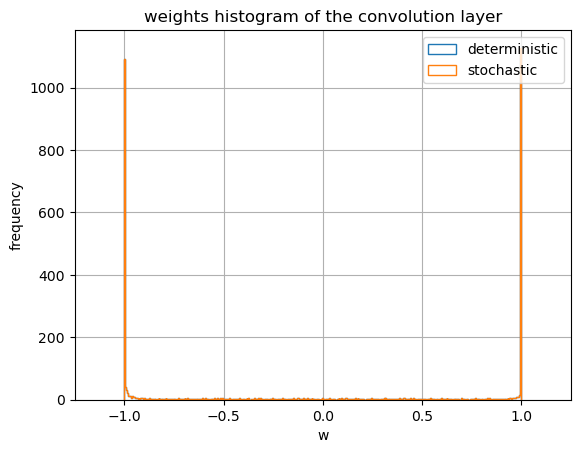

In [18]:
s_folder = r'./stochastic_1_1'
net_fn = os.path.join(s_folder, 'binarized_net.pt')
net_stochastic = BinaryNet()
net_stochastic.load_state_dict(torch.load(net_fn)) # load network trained by stochastic binarization
print("Skipped Training. Loaded network trained by stochastic binarization with binarizer being 1 and -1")
weight_list_stochastic = []
for layer in net_stochastic.features:
    if isinstance(layer, nn.Conv2d):
        weight_list_stochastic.append(torch.sort(layer.weight.detach().reshape(1, -1))[0])

d_folder = r'./deterministic_1_1'
net_fn = os.path.join(d_folder, 'binarized_net.pt')
net_deterministic = BinaryNet()
net_deterministic.load_state_dict(torch.load(net_fn)) # load network trained by stochastic binarization
print("Skipped Training. Loaded network trained by deterministic binarization with binarizer being 1 and -1")
weight_list_deterministic = []
for layer in net_stochastic.features:
    if isinstance(layer, nn.Conv2d):
        weight_list_deterministic.append(torch.sort(layer.weight.detach().reshape(1, -1))[0])


print(weight_list_deterministic)
print(weight_list_stochastic)

for weight_list_det, weight_list_sto in zip(weight_list_deterministic, weight_list_stochastic):
    fig, ax = plt.subplots()
    ax.hist(weight_list_det, bins=500, histtype="step", label="deterministic")
    ax.hist(weight_list_sto, bins=500, histtype="step", label="stochastic")
    ax.legend()
    ax.grid()
    ax.set_xlim(-1.25, 1.25)
    ax.set_xlabel('w')
    ax.set_ylabel('frequency')
    ax.set_title('weights histogram of the convolution layer')
    fig.savefig('./figure/weights histogram.png')
    break

Skipped Training. Loaded network trained by stochastic binarization with binarizer being 1 and -1
Skipped Training. Loaded network trained by deterministic binarization with binarizer being 1 and -1


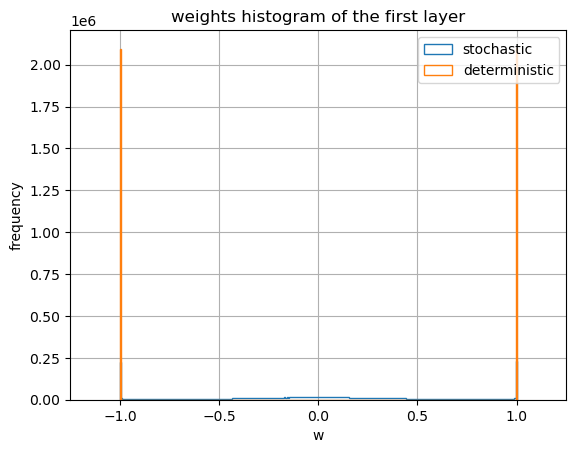

In [16]:
s_folder = r'./stochastic_1_1'
net_fn = os.path.join(s_folder, 'binarized_net.pt')
net_stochastic = BinaryNet()
net_stochastic.load_state_dict(torch.load(net_fn)) # load network trained by stochastic binarization
print("Skipped Training. Loaded network trained by stochastic binarization with binarizer being 1 and -1")
first_layer_stochastic_weight = net_stochastic.classifiers[0].weight.detach()
first_layer_stochastic_weight = first_layer_stochastic_weight.reshape(1, -1)
first_layer_stochastic_weight, indices = torch.sort(first_layer_stochastic_weight)

d_folder = r'./deterministic_1_1'
net_fn = os.path.join(d_folder, 'binarized_net.pt')
net_deterministic = BinaryNet()
net_deterministic.load_state_dict(torch.load(net_fn)) # load network trained by stochastic binarization
print("Skipped Training. Loaded network trained by deterministic binarization with binarizer being 1 and -1")
first_layer_deterministic_weight = net_deterministic.classifiers[0].weight.detach()
first_layer_deterministic_weight = first_layer_deterministic_weight.reshape(1, -1)
first_layer_deterministic_weight, indices = torch.sort(first_layer_deterministic_weight)

fig, ax = plt.subplots()
ax.hist(first_layer_stochastic_weight, bins=500, histtype="step", label="stochastic")
ax.hist(first_layer_deterministic_weight, bins=500, histtype="step", label="deterministic")
ax.legend()
ax.grid()
ax.set_xlim(-1.25, 1.25)
ax.set_xlabel('w')
ax.set_ylabel('frequency')
ax.set_title('weights histogram of the first layer')
fig.savefig('./figure/weights histogram.png')

Skipped Training. Loaded network trained by stochastic binarization with binarizer being 1 and -1
Skipped Training. Loaded network trained by deterministic binarization with binarizer being 1 and -1


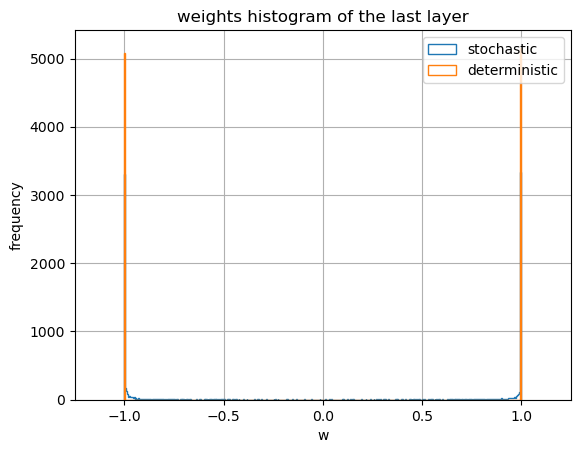

In [14]:
s_folder = r'./stochastic_1_1'
net_fn = os.path.join(s_folder, 'binarized_net.pt')
net_stochastic = BinaryNet()
net_stochastic.load_state_dict(torch.load(net_fn)) # load network trained by stochastic binarization
print("Skipped Training. Loaded network trained by stochastic binarization with binarizer being 1 and -1")
first_layer_stochastic_weight = net_stochastic.classifiers[2].weight.detach()
first_layer_stochastic_weight = first_layer_stochastic_weight.reshape(1, -1)
first_layer_stochastic_weight, indices = torch.sort(first_layer_stochastic_weight)

d_folder = r'./deterministic_1_1'
net_fn = os.path.join(d_folder, 'binarized_net.pt')
net_deterministic = BinaryNet()
net_deterministic.load_state_dict(torch.load(net_fn)) # load network trained by stochastic binarization
print("Skipped Training. Loaded network trained by deterministic binarization with binarizer being 1 and -1")
first_layer_deterministic_weight = net_deterministic.classifiers[2].weight.detach()
first_layer_deterministic_weight = first_layer_deterministic_weight.reshape(1, -1)
first_layer_deterministic_weight, indices = torch.sort(first_layer_deterministic_weight)

fig, ax = plt.subplots()
ax.hist(first_layer_stochastic_weight, bins=500, histtype="step", label="stochastic")
ax.hist(first_layer_deterministic_weight, bins=500, histtype="step", label="deterministic")
ax.legend()
ax.grid()
ax.set_xlim(-1.25, 1.25)
ax.set_xlabel('w')
ax.set_ylabel('frequency')
ax.set_title('weights histogram of the last layer')
fig.savefig('./figure/weights histogram.png')

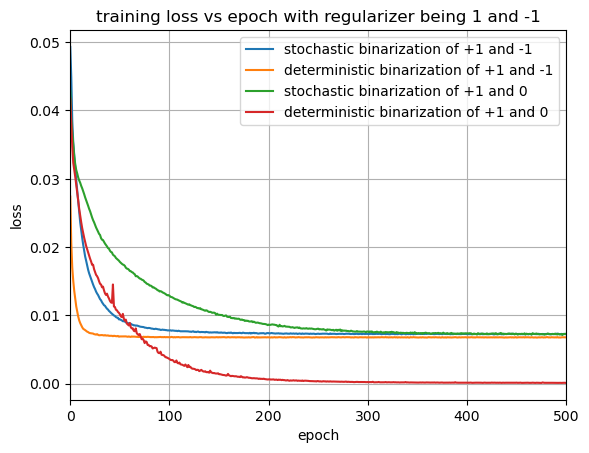

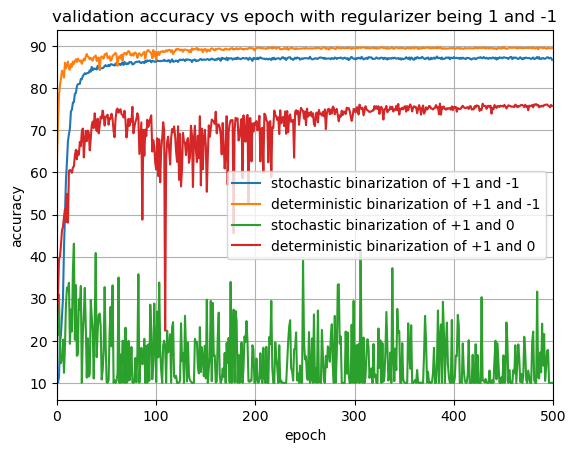

In [19]:
with open('./stochastic_1_1/train_loss_and_validation_accuracy.csv', 'r', encoding='UTF8') as f:
    csv_reader = csv.reader(f)
    stochastic_1_1 = list(csv_reader)
train_loss_of_every_epoch_stochastic_1_1 = stochastic_1_1[0]
train_loss_of_every_epoch_stochastic_1_1 = [float(e) for e in train_loss_of_every_epoch_stochastic_1_1]
validation_accuracy_of_every_epoch_stochastic_1_1 = stochastic_1_1[2]
validation_accuracy_of_every_epoch_stochastic_1_1 = [float(e) for e in validation_accuracy_of_every_epoch_stochastic_1_1]

with open('./deterministic_1_1/train_loss_and_validation_accuracy.csv', 'r', encoding='UTF8') as f:
    csv_reader = csv.reader(f)
    deterministic_1_1 = list(csv_reader)
train_loss_of_every_epoch_deterministic_1_1 = deterministic_1_1[0]
train_loss_of_every_epoch_deterministic_1_1 = [float(e) for e in train_loss_of_every_epoch_deterministic_1_1]
validation_accuracy_of_every_epoch_deterministic_1_1 = deterministic_1_1[2]
validation_accuracy_of_every_epoch_deterministic_1_1 = [float(e) for e in validation_accuracy_of_every_epoch_deterministic_1_1]

with open('./stochastic_1_0/train_loss_and_validation_accuracy.csv', 'r', encoding='UTF8') as f:
    csv_reader = csv.reader(f)
    stochastic_1_0 = list(csv_reader)
train_loss_of_every_epoch_stochastic_1_0 = stochastic_1_0[0]
train_loss_of_every_epoch_stochastic_1_0 = [float(e) for e in train_loss_of_every_epoch_stochastic_1_0]
validation_accuracy_of_every_epoch_stochastic_1_0 = stochastic_1_0[2]
validation_accuracy_of_every_epoch_stochastic_1_0 = [float(e) for e in validation_accuracy_of_every_epoch_stochastic_1_0]

with open('./deterministic_1_0/train_loss_and_validation_accuracy.csv', 'r', encoding='UTF8') as f:
    csv_reader = csv.reader(f)
    deterministic_1_0 = list(csv_reader)
train_loss_of_every_epoch_deterministic_1_0 = deterministic_1_0[0]
train_loss_of_every_epoch_deterministic_1_0 = [float(e) for e in train_loss_of_every_epoch_deterministic_1_0]
validation_accuracy_of_every_epoch_deterministic_1_0 = deterministic_1_0[2]
validation_accuracy_of_every_epoch_deterministic_1_0 = [float(e) for e in validation_accuracy_of_every_epoch_deterministic_1_0]

fig, ax = plt.subplots()
ax.plot(train_loss_of_every_epoch_stochastic_1_1, label="stochastic binarization of +1 and -1")
ax.plot(train_loss_of_every_epoch_deterministic_1_1, label="deterministic binarization of +1 and -1")
ax.plot(train_loss_of_every_epoch_stochastic_1_0, label="stochastic binarization of +1 and 0")
ax.plot(train_loss_of_every_epoch_deterministic_1_0, label="deterministic binarization of +1 and 0")
ax.legend()
ax.grid()
ax.set_xlim(0, 500)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('training loss vs epoch with regularizer being 1 and -1')
fig.savefig('./figure/train_loss_vs_epoch.png')

fig, ax = plt.subplots()
ax.plot(validation_accuracy_of_every_epoch_stochastic_1_1, label="stochastic binarization of +1 and -1")
ax.plot(validation_accuracy_of_every_epoch_deterministic_1_1, label="deterministic binarization of +1 and -1")
ax.plot(validation_accuracy_of_every_epoch_stochastic_1_0, label="stochastic binarization of +1 and 0")
ax.plot(validation_accuracy_of_every_epoch_deterministic_1_0, label="deterministic binarization of +1 and 0")
ax.legend()
ax.grid()
ax.set_xlim(0, 500)
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.set_title('validation accuracy vs epoch with regularizer being 1 and -1')
fig.savefig('./figure/validation_accuracy_vs_epoch.png')